# Main

In [1]:
from ColorMap import *
from tqdm import tqdm 
import pandas as pd
import cv2
from PSO import *

[[1, 0], [2, 3]]


In [2]:
N = 20
G = 100
sum_g = 0 #合計世代数
omega = 0.8
c1 = 2.6
c2 = 1.0
D = 2
up_lim = 5.0
lo_lim = -5.0
func = griewank_function
pso = PSO(N, omega, c1, c2, D, up_lim, lo_lim, func)
pso.init_phase()

In [3]:
color_map =  ColorMap(griewank_function, [-6, 6], [-6, 6] ,400, 400)
color_map.generate_coordinate()

100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


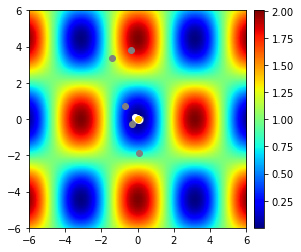

In [4]:
for g in tqdm(range(G)):
    pso.solution_search_phase()
    color_map.draw_map()
    pd_xs = pd.DataFrame(pso.xs)
    pd_pb = pd.DataFrame(pso.pb)
    color_map.draw_points(pd_xs[0], pd_xs[1], 'grey')   
    color_map.draw_points(pd_pb[0], pd_pb[1], 'white')
    color_map.draw_points([pso.gb[0]], [pso.gb[1]], 'gold')
    plt.savefig('output/images/img_' + str(sum_g + g)+ '.png')
sum_g = sum_g + G

In [5]:
#結果出力(動画)
# encoder(for mp4)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# output file name, encoder, fps, size(fit to image size)
video = cv2.VideoWriter('video.mp4',fourcc, 20.0, (432, 288))
if not video.isOpened():
    print("can't be opened")
    exit()
    
for i in tqdm(range(0, sum_g)):
    # hoge0000.png, hoge0001.png,..., hoge0090.png
    img = cv2.imread('output/images/img_' + str(i)+ '.png')

    # can't read image, escape
    if img is None:
        print("can't read")
        break

    # add
    video.write(img)
#     print("read image " + str(i))

video.release()
print('written')

100%|██████████| 100/100 [00:00<00:00, 329.12it/s]

written
